In [1]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as k

In [2]:
class MiniVGGNet:
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if k.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1

    # first CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    # return the constructed network architecture
    return model

In [3]:
from keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# load cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float") / 255.0
x_test = x_test.astype("float") / 255.0

no_of_classes = 10

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer",
"dog", "frog", "horse", "ship", "truck"]

In [5]:
(h, w, d) = x_train.shape[1:]
model = MiniVGGNet.build(h, w, d, no_of_classes)

In [6]:
opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, epochs=40, verbose=1)

Epoch 1/40
782/782 [==============================] - 10s 9ms/step - loss: 1.9824 - accuracy: 0.3768 - val_loss: 1.5812 - val_accuracy: 0.4869
Epoch 2/40
782/782 [==============================] - 6s 8ms/step - loss: 1.2097 - accuracy: 0.5839 - val_loss: 0.9572 - val_accuracy: 0.6608
Epoch 3/40
782/782 [==============================] - 6s 8ms/step - loss: 0.9973 - accuracy: 0.6501 - val_loss: 0.8041 - val_accuracy: 0.7211
Epoch 4/40
782/782 [==============================] - 6s 8ms/step - loss: 0.8720 - accuracy: 0.6956 - val_loss: 0.8532 - val_accuracy: 0.6979
Epoch 5/40
782/782 [==============================] - 6s 8ms/step - loss: 0.7949 - accuracy: 0.7152 - val_loss: 0.7585 - val_accuracy: 0.7355
Epoch 6/40
782/782 [==============================] - 7s 8ms/step - loss: 0.7313 - accuracy: 0.7391 - val_loss: 0.7285 - val_accuracy: 0.7518
Epoch 7/40
782/782 [==============================] - 6s 8ms/step - loss: 0.6881 - accuracy: 0.7555 - val_loss: 0.6699 - val_accuracy: 0.7669
Epoch

In [8]:
preds = model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names=labelNames))

              precision    recall  f1-score   support

    airplane       0.87      0.81      0.84      1000
  automobile       0.91      0.92      0.91      1000
        bird       0.78      0.71      0.74      1000
         cat       0.65      0.70      0.67      1000
        deer       0.76      0.80      0.78      1000
         dog       0.72      0.75      0.74      1000
        frog       0.83      0.89      0.86      1000
       horse       0.89      0.84      0.87      1000
        ship       0.91      0.91      0.91      1000
       truck       0.90      0.88      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



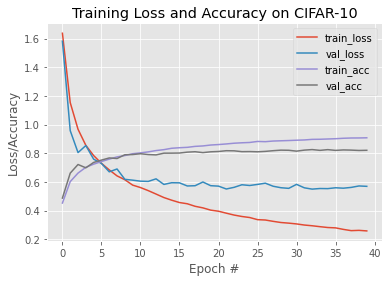

In [9]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()